Number of classes: 2
Using device: cuda
Epoch 1/10 | Train Loss: 0.8619 | Train Acc: 46.63% | Val Loss: 0.7921 | Val Acc: 51.46%
✅ Best model saved at epoch 1 with val acc: 51.46%
Epoch 2/10 | Train Loss: 0.8607 | Train Acc: 46.42% | Val Loss: 0.7865 | Val Acc: 52.43%
✅ Best model saved at epoch 2 with val acc: 52.43%
Epoch 3: Unfreezing backbone...
Epoch 3/10 | Train Loss: 0.8349 | Train Acc: 48.38% | Val Loss: 0.7577 | Val Acc: 50.49%
Epoch 4/10 | Train Loss: 0.7959 | Train Acc: 51.33% | Val Loss: 0.7314 | Val Acc: 51.46%
Epoch 5/10 | Train Loss: 0.7843 | Train Acc: 52.87% | Val Loss: 0.7106 | Val Acc: 51.46%
Epoch 6/10 | Train Loss: 0.7522 | Train Acc: 55.79% | Val Loss: 0.6943 | Val Acc: 51.46%
Epoch 7/10 | Train Loss: 0.7374 | Train Acc: 57.06% | Val Loss: 0.6829 | Val Acc: 51.46%
Epoch 8/10 | Train Loss: 0.7150 | Train Acc: 57.96% | Val Loss: 0.6760 | Val Acc: 51.46%
Epoch 9/10 | Train Loss: 0.7185 | Train Acc: 58.41% | Val Loss: 0.6728 | Val Acc: 51.46%
Epoch 10/10 | Train Loss:

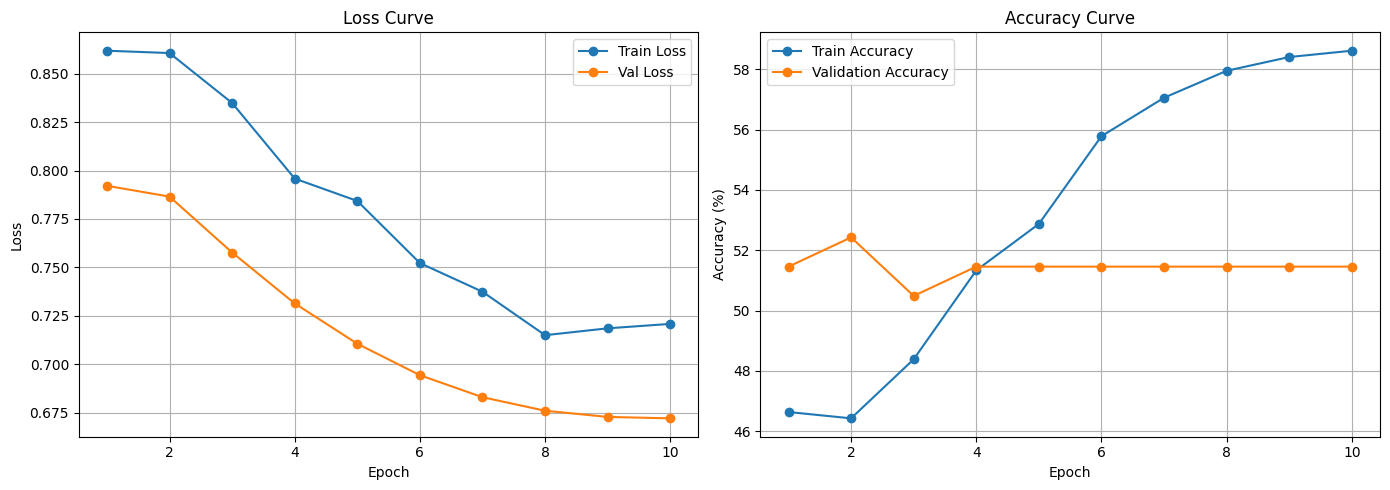

In [ ]:
"""
NOTE:
===========
Learning rates are now even smaller to minimize overfitting:

- Classifier LR: 5e-7 ✅
- Backbone LR:   1e-7 ✅
===========
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import random
import os
import matplotlib.pyplot as plt

# -------------------------
# 1) Reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything()

# -------------------------
# 2) Paths
train_dir = "/content/drive/MyDrive/5000 IMAGES"
val_dir = "/content/drive/MyDrive/VALIDATION"

# -------------------------
# 3) Transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

# -------------------------
# 4) Datasets and Dataloaders
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

# -------------------------
# 5) Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -------------------------
# 6) ConvNeXt-Tiny Model
model = models.convnext_tiny(pretrained=True)

# Freeze backbone initially
for param in model.features.parameters():
    param.requires_grad = False

# Replace classifier
model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.LayerNorm(768, eps=1e-6),
    nn.Dropout(0.7),
    nn.Linear(768, num_classes)
)
model = model.to(device)

# -------------------------
# 7) Loss Function, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Extremely low initial learning rates to reduce overfitting
optimizer = optim.AdamW([
    {"params": model.classifier.parameters(), "lr": 5e-7},
    {"params": model.features.parameters(), "lr": 0.0}  # frozen initially
], weight_decay=1e-3)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# -------------------------
# 8) Training Setup
num_epochs = 10
unfreeze_epoch = 3

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_acc = 0

# -------------------------
# 9) Training Loop
for epoch in range(1, num_epochs + 1):
    if epoch == unfreeze_epoch:
        print(f"Epoch {epoch}: Unfreezing backbone...")
        for param in model.features.parameters():
            param.requires_grad = True
        optimizer = optim.AdamW([
            {"params": model.classifier.parameters(), "lr": 5e-7},
            {"params": model.features.parameters(), "lr": 1e-7}
        ], weight_decay=1e-3)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs - epoch + 1)

    # --- Training ---
    model.train()
    train_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    train_loss /= total
    train_acc = 100 * correct / total

    # --- Validation ---
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    val_loss /= total
    val_acc = 100 * correct / total

    # --- Logging ---
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    scheduler.step()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print(f"✅ Best model saved at epoch {epoch} with val acc: {val_acc:.2f}%")

print(f"\n🎯 Training complete. Best validation accuracy: {best_val_acc:.2f}%")

# -------------------------
# 10) Plotting Curves
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss', marker='o')
plt.plot(epochs_range, val_losses, label='Val Loss', marker='o')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


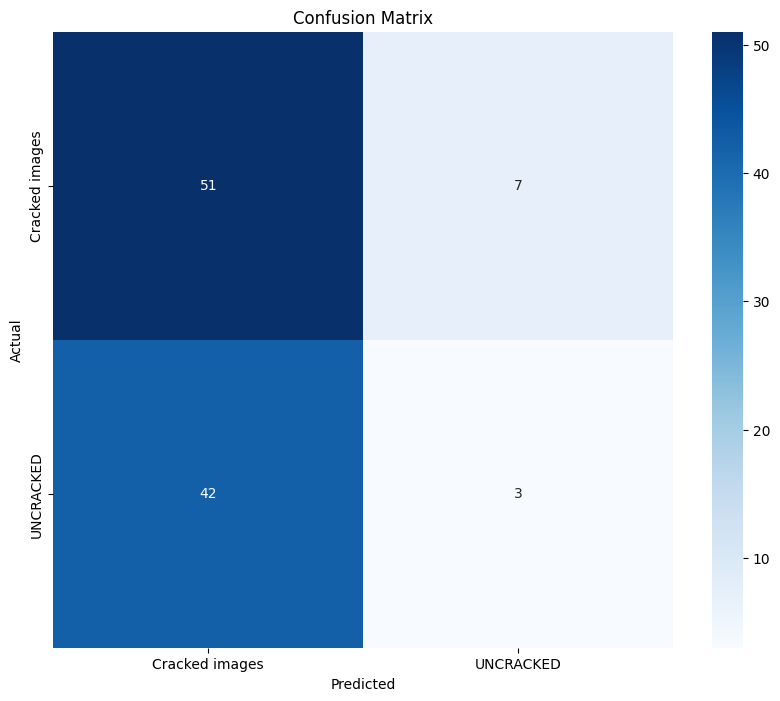

Classification Report:

                precision    recall  f1-score   support

Cracked images       0.55      0.88      0.68        58
     UNCRACKED       0.30      0.07      0.11        45

      accuracy                           0.52       103
     macro avg       0.42      0.47      0.39       103
  weighted avg       0.44      0.52      0.43       103



In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# ----------------------------
# SETTINGS: Set your paths here
model_path = "/content/best_model.pth"   # 🔁 Change this to your model file path
val_dir = "/content/drive/MyDrive/VALIDATION"                 # 🔁 Path to validation folder

# ----------------------------
# Define transform for validation
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

# Load validation data
val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class_names = val_dataset.classes
num_classes = len(class_names)

# ----------------------------
# Load model and weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.convnext_tiny()
model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.LayerNorm(768, eps=1e-6),
    nn.Dropout(0.7),
    nn.Linear(768, num_classes)
)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# ----------------------------
# Inference
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

# ----------------------------
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ----------------------------
# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n")
print(report)